In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c digit-recognizer

  0% 0.00/6.09M [00:00<?, ?B/s]
100% 6.09M/6.09M [00:00<00:00, 96.6MB/s]
 55% 5.00M/9.16M [00:00<00:00, 30.4MB/s]
100% 9.16M/9.16M [00:00<00:00, 44.8MB/s]
  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 78.0MB/s]


In [ ]:
! unzip 'train.csv.zip'
! unzip 'test.csv.zip'

Archive:  train.csv.zip
  inflating: train.csv               
Archive:  test.csv.zip
  inflating: test.csv                


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split,DataLoader,TensorDataset

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd


In [ ]:
train=pd.read_csv("/content/train.csv")
test=pd.read_csv("/content/test.csv")

In [ ]:
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
len(train)


42000

In [ ]:
len(test)


28000

In [ ]:
train.shape


(42000, 785)

In [ ]:
test.shape

(28000, 784)

In [ ]:
labels=train.label

In [ ]:
train_ds=train.drop('label',axis=1)

In [ ]:
train_ds.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


0


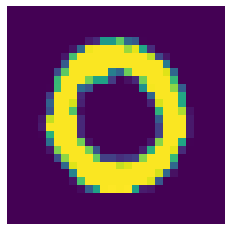

In [ ]:
plt.imshow(train_ds[1:2].values.reshape(28,28))
plt.axis("off")
print(labels[1])

In [ ]:
train_ds=train_ds.values
test_ds=test.values
labels=labels.to_numpy()

In [ ]:
train_ds=torch.tensor(train_ds)
test_ds =torch.tensor(test_ds)
labels = torch.tensor(labels)

In [ ]:
traiin_ds=TensorDataset(train_ds,labels)

In [ ]:
traiin_ds[0:2]

(tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]), tensor([1, 0]))

In [ ]:
train_ds , val_ds = random_split(traiin_ds,(32000,10000))

In [ ]:
train_loader=DataLoader(train_ds , batch_size=128, shuffle = True)
val_loader=DataLoader(val_ds , batch_size=128, shuffle = False)

In [ ]:
test_loader=DataLoader(test_ds , batch_size=128, shuffle = False)

In [ ]:
input_size = 784
num_class = 10

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
                                                                        
        self.conv1 = nn.Conv2d(
                                in_channels=1,
                                out_channels=8,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=(1, 1)
        )                                                                
        
        self.pool = nn.MaxPool2d(
                                 kernel_size=(2, 2),
                                 stride=(2, 2)
        )                                                               
                                                                        
        
        self.conv2 = nn.Conv2d(
                                in_channels=8,
                                out_channels=16,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=(1, 1),
        )                                                            
        
        self.fc1 = nn.Linear(16 * 7 * 7, num_class)

    def forward(self, x):
        x = F.relu(self.conv1(x))                                      # 8,28,28
        x = self.pool(x)                                               # 8,14,14
        x = F.relu(self.conv2(x))                                      # 16,14,14
        x = self.pool(x)                                               #16,7,7
        
#         print(x.shape)
        x = x.reshape(x.shape[0], -1)
    
        x = self.fc1(x)
        return x
    
model = CNN().to('cuda')

In [ ]:
opt      = torch.optim.Adam
opt = opt(model.parameters())

In [ ]:
def fit(epochs,model,data):
    
    loss_fun = F.cross_entropy
    hist = []
    for Epoch in range(epochs):
        for img,label in data:
            img = img.reshape(img.shape[0],1,28,28)
            img=img.to('cuda')
            label= label.to('cuda')
#             print(img.shape)
            out = model(img/255)
            loss = loss_fun(out,label)
            loss.backward()
            opt.step()
            opt.zero_grad()
            hist.append(loss)
        
        if (Epoch+1)%50==0:
            print(f"Epoch:[{Epoch+1}/{epochs}] ; Loss : {loss:.4f}")
    return hist

In [ ]:
hist=fit(500,model,train_loader)

Epoch:[50/500] ; Loss : 0.0155
Epoch:[100/500] ; Loss : 0.0260
Epoch:[150/500] ; Loss : 0.0000
Epoch:[200/500] ; Loss : 0.0000
Epoch:[250/500] ; Loss : 0.0000
Epoch:[300/500] ; Loss : 0.0000
Epoch:[350/500] ; Loss : 0.0000
Epoch:[400/500] ; Loss : 0.0000
Epoch:[450/500] ; Loss : 0.0000
Epoch:[500/500] ; Loss : 0.0000


In [ ]:
def acc(data):
    accy=[]
    for img ,label in data:
        img = img.reshape(img.shape[0],1,28,28)
        img,label = img.to('cuda'),label.to('cuda')
        out=model(img/255)
#         out=F.softmax(out)
        _,pred_index=torch.max(out,dim=1)
        x=torch.sum(pred_index==label)/len(pred_index)
        x=x*100
        x=x.to("cpu").numpy()
        accy.append(x)
        
        
    return np.mean(accy)  

In [ ]:
acc(val_loader)

98.42761